# Implementation of Easy21

## Rules
- The game is played with an infinite deck of cards (i.e. cards are sampled
with replacement)
- Each draw from the deck results in a value between 1 and 10 (uniformly
distributed) with a colour of red (probability 1/3) or black (probability
2/3).
- There are no aces or picture (face) cards in this game
- At the start of the game both the player and the dealer draw one black
card (fully observed)
- Each turn the player may either stick or hit
- If the player hits then she draws another card from the deck
- If the player sticks she receives no further cards
- The values of the player’s cards are added (black cards) or subtracted (red
cards)
- If the player’s sum exceeds 21, or becomes less than 1, then she “goes
bust” and loses the game (reward -1)
- If the player sticks then the dealer starts taking turns. The dealer always
sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes
bust, then the player wins; otherwise, the outcome – win (reward +1),
lose (reward -1), or draw (reward 0) – is the player with the largest sum.

In [67]:
import numpy as np
np.random.seed(42)
def draw_from_deck(black: bool = False) -> int:
    """
    Args:
    black: if True the function will return a positive valued card (Start of game)
    Returns: a sampled card from the deck
    """
    
    card = np.random.choice(10) + 1
    return card if (np.random.choice(2, p= [1/3, 2/3]) or black) else -card

In [68]:
def step(s: list, a :str = 'hit'): 
    """
    Args:
    s: State (list like), dealer's first card 1-10  and the player's sum 1-21
    a: Action, hit or stick

    Returns: a sample of the next state s' (which may be terminal if the game is finished) and reward r
    """
    player_sum = s[1]
    dealer_sum = s[0]

    if a == 'stick':
        while dealer_sum < 17:
            dealer_sum += draw_from_deck()
            if dealer_sum < 1 or dealer_sum > 21:
                return [dealer_sum, player_sum], 1
        
        if dealer_sum > player_sum:
            return [dealer_sum, player_sum], -1
        elif dealer_sum == player_sum:
            return [dealer_sum, player_sum], 0
        else:
            return [dealer_sum, player_sum], 1
    else:
        player_sum += draw_from_deck()
        if player_sum < 1 or player_sum > 21:
            return [dealer_sum, player_sum], -1
        else:
            return [dealer_sum, player_sum], None

***

# Monte-Carlo Control in Easy21

## Rules:
Apply Monte-Carlo control to Easy21. Initialise the value function to zero. Use
a time-varying scalar step-size of $a_t = 1 / N(s_t, a_t)$ nd an ε-greedy exploration
strategy with $ε_t = N_0 / (N_0 + N(s_t))$, where $N_0 = 100$ is a constant, $N(s)$ is the number of times that state s has been visited, and $N(s,a)$ is the number 
of times that action $a$ has been selected from state s. Feel free to choose an alternative value for $N_0$, if it helps producing better results. Plot the optimal value function $V^*(s) = max_aQ^*(s,a)$ using similar axes to the following figure.

In [249]:
# N
N_0 = 10000
n_table_state = np.zeros(shape= (10,21), dtype = int)
n_table_action = np.zeros(shape= (10,21,2), dtype = int)

# q table
q_table = np.zeros(shape = (10,21,2), dtype= float) # 0 for staying, 1 for hitting

# Policy
policy = ['greedy', 'random']

In [250]:
num_episodes = 10000000
for i in range(num_episodes):
    state_zero = [draw_from_deck(True), draw_from_deck(True)] #Initial card draws for dealer (s[0]) and player (s[1])

    moves = [state_zero]
    reward = None

    # Episode
    while reward == None:
        # Choose move
        e_t = N_0 / (N_0 + n_table_state[moves[-1][0] - 1, moves[-1][1] - 1])

        action = np.random.choice(policy, p= [1-e_t, e_t])

        if action == 'random':
            next_move = np.random.choice(['hit', 'stick'])
        else:
            if q_table[moves[-1][0] - 1, moves[-1][1] - 1][0] >= q_table[moves[-1][0] - 1, moves[-1][1] - 1][1]:
                next_move = 'stick'
            else: 
                next_move = 'hit'

        # Move
        state, reward = step(moves[-1], next_move)
        moves.append(state)
    
    for i in range(len(moves) - 1):
        n_table_state[moves[i][0] - 1, moves[i][1] - 1] += 1    # Doesn't matter if we hit or stayed

        if moves[i][1] == moves[i+1][1]:  # We stayed
            n_table_action[moves[i][0] - 1, moves[i][1] - 1][0] += 1

            q_table[moves[i][0] - 1, moves[i][1] - 1][0] += (1 /n_table_action[moves[i][0] - 1, moves[i][1] - 1][0]) * (reward - q_table[moves[i][0] - 1, moves[i][1] - 1][0])
        else:   # We hit
            n_table_action[moves[i][0] - 1, moves[i][1] - 1][1] += 1

            q_table[moves[i][0] - 1, moves[i][1] - 1][1] += (1 /n_table_action[moves[i][0] - 1, moves[i][1] - 1][1]) * (reward - q_table[moves[i][0] - 1, moves[i][1] - 1][1])

In [251]:
# Create a value table, storing the best action value for each state
value_table = np.zeros(shape= (10,21), dtype= float)
policy_table = np.empty(shape= (10,21), dtype= object)
for i in range(10):
    for j in range(21):
        value_table[i,j] = max(q_table[i,j][0], q_table[i,j][1])
        policy_table[i,j] = 'stay' if q_table[i,j][0] > q_table[i,j][1] else 'hit'

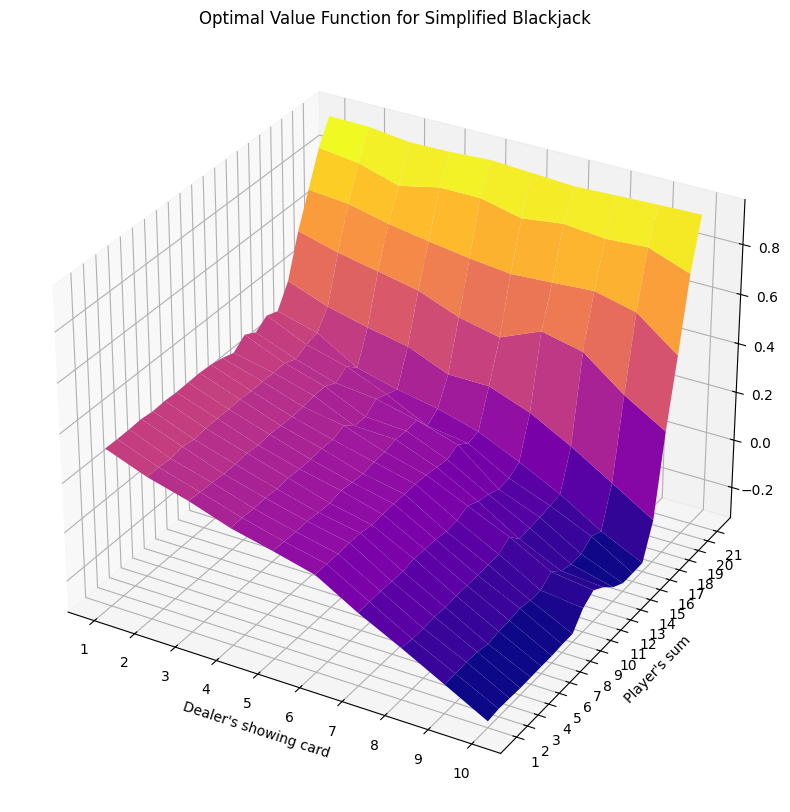

In [252]:
# Plot the optimal value function as a 3d grid plot with black and white colormap
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(14, 10)
ax = fig.add_subplot(111, projection='3d')
X = np.arange(1,11)
Y = np.arange(1,22)
X, Y = np.meshgrid(X, Y)
# Black and white colormap
ax.plot_surface(X, Y, value_table.T, cmap='plasma')
ax.set_xlabel("Dealer's showing card")
ax.set_ylabel("Player's sum")



# Set x ticks and y ticks
ax.set_xticks(np.arange(1, 11, 1))
ax.set_yticks(np.arange(1, 22, 1))

# Title 
ax.set_title("Optimal Value Function for Simplified Blackjack")

plt.show()

In [253]:
# Interpretation of results
dealer_card = 10
your_card = 15
value_table[dealer_card-1, your_card-1] # Your expected return starting from this state
policy_table[dealer_card-1, your_card-1] # Your optimal action from this state
print(f"From state (dealer's card: {dealer_card}, your card: {your_card}), your expected return is {value_table[dealer_card-1, your_card-1]:.2f} and your optimal action is to {policy_table[dealer_card-1, your_card-1]}.")

From state (dealer's card: 10, your card: 15), your expected return is -0.29 and your optimal action is to stay.


***

# TD Learning in Easy21

## Rules: 
Implement $Sarsa(λ)$ in 21s. Initialise the value function to zero. Use the same step-size and exploration sxhedules as in the previous section. Run the algorithm with parameter values $λ \in \{0, 0.1, 0.2, \dots, 1\}$. Stop each run after 1000 episodes and report the mean-squared error $\sum _{s,a} (Q(s,a) - Q^*(s,a))^2$ over all states $s$ actions $a$, comparing the true values $Q^*(s,a)$ computed in the previous section with the estiamted values $Q(s,a)$ computed by Sarsa. Plot the mean-squared error against $λ$. For $λ=0$ and $λ=1$ only, plot the learning curve of mean-squared error against episode number.

In [82]:
# N
N_0 = 1000
n_table_state = np.zeros(shape= (10,21), dtype = int)
n_table_action = np.zeros(shape= (10,21,2), dtype = int)

# q table
q_table = np.zeros(shape = (10,21,2), dtype= float) # 0 for staying, 1 for hitting

# Policy
policy = ['greedy', 'random']

move_dictionary = {
    'stick' : 0,
    'hit' : 1
}

In [83]:
num_episodes = 10000
l = 0.1
np.random.seed(42)
for i in range(num_episodes):
    # Initial state
    state = [draw_from_deck(True), draw_from_deck(True)] # Initial card draws for dealer (s[0]) and player (s[1])
    reward = None

    eligibility_table = np.zeros_like(q_table)

    n_table_state[state[0] - 1,state[1] - 1] += 1

    # Initial action
    e_t = N_0 / (N_0 + n_table_state[state[0] - 1,state[1] - 1])
    action = np.random.choice(policy, p= [1-e_t, e_t])
    if action == 'random':
        first_move = np.random.choice(['hit', 'stick'])
    else:
        if q_table[state[0] - 1,state[1] - 1][0] >= q_table[state[0] - 1,state[1] - 1][1]:
            first_move = 'stick'
        else: 
            first_move = 'hit'
    
    n_table_action[state[0] - 1,state[1] - 1][move_dictionary[first_move]] += 1

    # Episode
    while reward == None:
        # Take action, observe R, S' 
        next_state, reward = step(state, first_move)
        if reward == None:
            n_table_state[next_state[0] - 1,next_state[1] - 1] += 1

            # Choose A' from S' using ε-greedy policy
            e_t = N_0 / (N_0 + n_table_state[next_state[0] - 1,next_state[1] - 1])

            action = np.random.choice(policy, p= [1-e_t, e_t])

            if action == 'random':
                next_move = np.random.choice(['hit', 'stick'])
            else:
                if q_table[next_state[0] - 1,next_state[1] - 1][0] >= q_table[next_state[0] - 1,next_state[1] - 1][1]:
                    next_move = 'stick'
                else: 
                    next_move = 'hit'
            
            n_table_action[next_state[0] - 1,next_state[1] - 1][move_dictionary[next_move]] += 1
            # Calculate δ
            delta = 0 + 1 * q_table[next_state[0] - 1,next_state[1] - 1][move_dictionary[next_move]] - q_table[state[0] - 1,state[1] - 1][move_dictionary[first_move]]
            
            eligibility_table[state[0] - 1,state[1] - 1][move_dictionary[first_move]] += 1
            
            # State Action Function updates (vectorized):
            alpha = np.zeros_like(q_table, dtype=float)
            np.divide(1.0, n_table_action, out=alpha, where=n_table_action>0)
            q_table += alpha * delta * eligibility_table
            eligibility_table *= 1 * l


            state = next_state
            first_move = next_move
        else: # Final State
            delta = reward + 0 - q_table[state[0] - 1,state[1] - 1][move_dictionary[first_move]]

            eligibility_table[state[0] - 1,state[1] - 1][move_dictionary[first_move]] += 1
            
            # State Action Function updates (vectorized):
            alpha = np.zeros_like(q_table, dtype=float)
            np.divide(1.0, n_table_action, out=alpha, where=n_table_action>0)
            q_table += alpha * delta * eligibility_table
            eligibility_table *= 1 * l

In [84]:
monte_carlo_q_table = np.load('monte_carlo_q_table.npy')

np.mean((monte_carlo_q_table - q_table) ** 2)

np.float64(0.032169850226998496)

In [59]:
# Create a value table, storing the best action value for each state
value_table = q_table.max(axis=2)  # best action value per state
policy_table = np.where(q_table[..., 0] > q_table[..., 1], 'stay', 'hit') # best policy per state

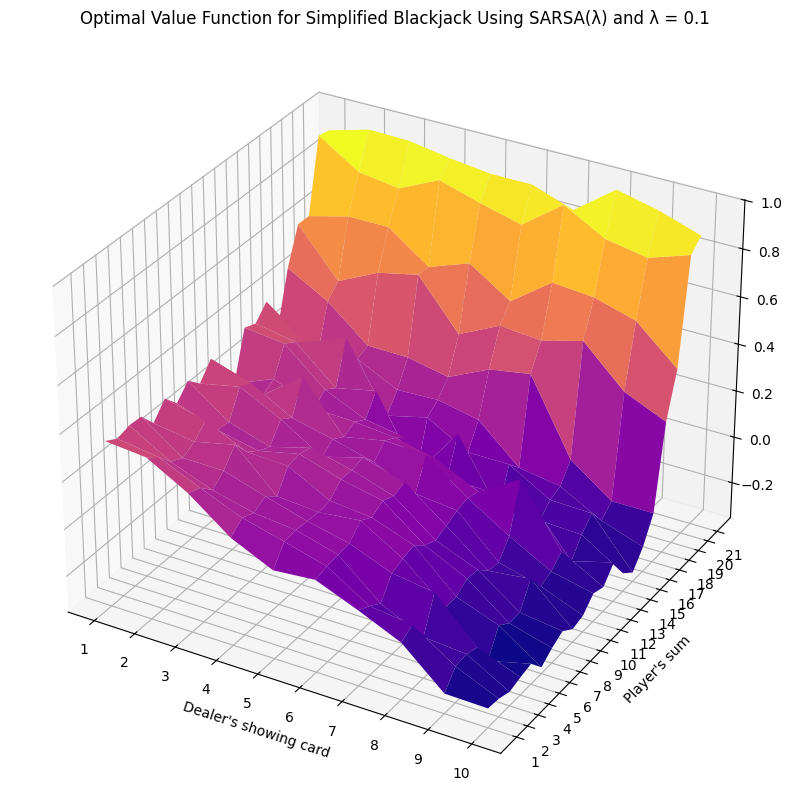

In [85]:
# Plot the optimal value function as a 3d grid plot with black and white colormap
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(14, 10)
ax = fig.add_subplot(111, projection='3d')
X = np.arange(1,11)
Y = np.arange(1,22)
X, Y = np.meshgrid(X, Y)
# Black and white colormap
ax.plot_surface(X, Y, value_table.T, cmap='plasma')
ax.set_xlabel("Dealer's showing card")
ax.set_ylabel("Player's sum")



# Set x ticks and y ticks
ax.set_xticks(np.arange(1, 11, 1))
ax.set_yticks(np.arange(1, 22, 1))

# Title 
ax.set_title("Optimal Value Function for Simplified Blackjack Using SARSA(λ) and λ = 0.1")

plt.show()